### Stan
Using the statistical modelling software stan (here Pystan) to use the PMCMC algorithm to solve the SARS-CoV-2 model. 

In [1]:
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set()  # Nice plot aesthetic
np.random.seed(101)

# model needs to be written in stan
model = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(alpha + beta * x, sigma);
}
"""

In [4]:
# Parameters to be inferred
alpha = 4.0
beta = 0.5
sigma = 1.0

# Generate and plot data
x = 10 * np.random.rand(100)
y_true = alpha + beta * x
y = np.random.normal(y_true, scale=sigma)

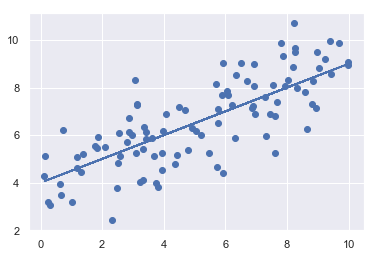

In [5]:
plt.scatter(x,y)
plt.plot(x,y_true)

In [7]:
# Put our data in a dictionary
data = {'N': len(x), 'x': x, 'y': y}

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cb4cc9c2a04d0e34d711077557307fb7 NOW.


In [8]:
print(fit)

Inference for Stan model: anon_model_cb4cc9c2a04d0e34d711077557307fb7.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   3.88  9.1e-3   0.25    3.4   3.71   3.87   4.04   4.36    744    1.0
beta    0.53  1.6e-3   0.04   0.44    0.5   0.53   0.56   0.61    763    1.0
sigma   1.19  2.6e-3   0.09   1.03   1.13   1.19   1.24   1.37   1109    1.0
lp__  -65.99    0.05   1.25 -69.27 -66.58 -65.68 -65.09 -64.56    699    1.0

Samples were drawn using NUTS at Fri Mar 27 00:35:14 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [9]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

alpha_mean, beta_mean = df['mean']['alpha'], df['mean']['beta']

# Extracting traces
alpha = fit['alpha']
beta = fit['beta']
sigma = fit['sigma']
lp = fit['lp__']

In [12]:
def plot_trace(param, param_name='parameter'):
  """Plot the trace and posterior of a parameter."""
  
  # Summary statistics
  mean = np.mean(param)
  median = np.median(param)
  cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
  
  # Plotting
  plt.subplot(2,1,1)
  plt.plot(param)
  plt.xlabel('samples')
  plt.ylabel(param_name)
  plt.axhline(mean, color='r', lw=2, linestyle='--')
  plt.axhline(median, color='c', lw=2, linestyle='--')
  plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
  plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
  plt.title('Trace and Posterior Distribution for {}'.format(param_name))

  plt.subplot(2,1,2)
  plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
  plt.xlabel(param_name)
  plt.ylabel('density')
  plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
  plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
  plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
  plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
  plt.gcf().tight_layout()
  plt.legend()

C:\Users\henri\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


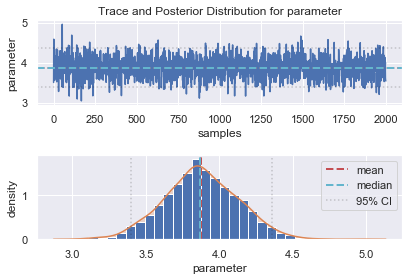

In [13]:
plot_trace(alpha, param_name='parameter')